In [13]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

### <font color=blue> Prep data.

In [14]:
from epsampling.modeling import get_full_modeling_dfs

df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')

# df = df[df.True_inc_deaths > 0]

# df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1/100000) / x.Pop * 100000, axis=1)
# df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1/100000) / x.Pop * 100000, axis=1)
# df['State'] = df.apply(lambda x: (x.Proj_inc_deaths+1/100000) / x.State_pop * 100000, axis=1)
# df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1/100000) / x.Pop * 100000, axis=1)

df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
df['State'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)

# df['Target'] = df.apply(lambda x: (x.True_inc_deaths / x.Pop + 1) * 100000, axis=1)
# df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths / x.Pop + 1) * 100000, axis=1)
# df['State'] = df.apply(lambda x: (x.Proj_inc_deaths / x.State_pop + 1) * 100000, axis=1)
# df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1 / x.Pop + 1) * 100000, axis=1)

# df['Target'] = df.apply(lambda x: x.True_inc_deaths, axis=1)
# df['Naive'] = df.apply(lambda x: x.Naive_inc_deaths, axis=1)
# df['State'] = df.apply(lambda x: x.Proj_inc_deaths, axis=1)
# df['Cumtm1'] = df.apply(lambda x: x.Cum_deaths_tm1, axis=1)


# df['Target'] = df.apply(lambda x: x.True_inc_deaths + 1, axis=1)
# df['Naive'] = df.apply(lambda x: x.Naive_inc_deaths + 1, axis=1)
# df['State'] = df.apply(lambda x: x.Proj_inc_deaths + 1, axis=1)
# df['Cumtm1'] = df.apply(lambda x: x.Cum_deaths_tm1 + 1, axis=1)

# df['Target'].describe()

In [15]:
# df = df[df.True_inc_deaths > 0]

In [16]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# df['Target'].describe(), df['Naive'].describe()

In [20]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
# random.seed(666)

chunks = get_chunks(list(df.Date.unique()), 4)
idc = random.sample(range(len(chunks)), 4, )

alg = 'lasso'

metrics_dicts = []

for idx in tqdm(idc):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx, samp_frac=0.5)
#     df_train = (df_train-df_train.mean())/df_train.std()

    feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
                                   'State_pop','Ratio','Pop']
    
#     feats = ['POP_NHPINH', 'POP_OTH2PLNH', 'POP_ASIANNH', 'POP_AIANNH',
#              'POP_HISP_x12', 'POP_NH', 'POP_BLACKNH', 'POP_WHITENH','IND_WHT_x7', 
#              'EDU_BACH', 'HHI_150_200k'] + ['State','Cumtm1','Naive','State_pop','Ratio','Pop']
    
#     feats = ['State','Cumtm1','Naive','State_pop','Ratio','Pop']
    
#     feats = ['POP_NHPINH', 'POP_OTH2PLNH', 'POP_ASIANNH', 'POP_AIANNH',
#              'POP_HISP_x12', 'POP_NH', 'POP_BLACKNH', 'POP_WHITENH','IND_WHT_x7', 
#              'EDU_BACH', 'HHI_150_200k'] +  ['State','Cumtm1','Naive',
#                                    'State_pop','Ratio','Pop']
    
#     feats = ['POP_NHPINH', 'POP_OTH2PLNH', 'POP_ASIANNH', 'POP_AIANNH',
#              'POP_HISP_x12', 'POP_NH', 'POP_BLACKNH', 'POP_WHITENH','IND_WHT_x7', 
#              'EDU_BACH', 'HHI_150_200k'] 
        
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
#     print(y_train.max(), y_train.min(), y_test.max(), y_test.min())
    
    if alg=='linear':
        reg = LinearRegression().fit(X_train, y_train)
    elif alg=='lasso':
        reg = Lasso(alpha=0.25).fit(X_train, y_train)

    
    y_pred = reg.predict(X_test)
    y_naive = df_test['Naive']

    model_names = ['Deaths_pred', 'Deaths_naive']
    model_preds = [y_pred, y_naive]

    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
    metrics_dicts.append(metrics_dict)
    
for i,metrics_dict in enumerate(metrics_dicts):
    print(f'\n\n=== RUN {i} ===')
    for k,v in metrics_dict.items():
        print(f' {k}')
        for k2,v2 in v.items():
            if k2=='r2':
                k3 = 'r-squared'
            else:
                k3 = k2
            print(f' • {k3}: \t{round(v2,5)}')

100%|██████████| 4/4 [00:06<00:00,  1.72s/it]



=== RUN 0 ===
 Deaths_pred
 • MAE: 	5.19235
 • MedAE: 	4.06205
 • MSE: 	61.24904
 • RMSE: 	7.82618
 • r-squared: 	0.97237
 • relMAE: 	2.64104
 • relMedAE: 	1.32075
 Deaths_naive
 • MAE: 	4.89715
 • MedAE: 	3.43228
 • MSE: 	63.59898
 • RMSE: 	7.9749
 • r-squared: 	0.97131
 • relMAE: 	1.0
 • relMedAE: 	1.0


=== RUN 1 ===
 Deaths_pred
 • MAE: 	2.4294
 • MedAE: 	1.66043
 • MSE: 	22.59856
 • RMSE: 	4.75379
 • r-squared: 	0.97247
 • relMAE: 	2.48803
 • relMedAE: 	1.81728
 Deaths_naive
 • MAE: 	1.93639
 • MedAE: 	0.8142
 • MSE: 	22.62146
 • RMSE: 	4.7562
 • r-squared: 	0.97244
 • relMAE: 	1.0
 • relMedAE: 	1.0


=== RUN 2 ===
 Deaths_pred
 • MAE: 	3.2757
 • MedAE: 	1.95795
 • MSE: 	139.20513
 • RMSE: 	11.79852
 • r-squared: 	0.95102
 • relMAE: 	2.40939
 • relMedAE: 	1.59955
 Deaths_naive
 • MAE: 	2.78939
 • MedAE: 	1.18657
 • MSE: 	139.5322
 • RMSE: 	11.81238
 • r-squared: 	0.9509
 • relMAE: 	1.0
 • relMedAE: 	1.0


=== RUN 3 ===
 Deaths_pred
 • MAE: 	5.37537
 • MedAE: 	3.50348
 • MSE: 	93

In [11]:
# # # # # # # # # #
how_many = 8
# # # # # # # # # #

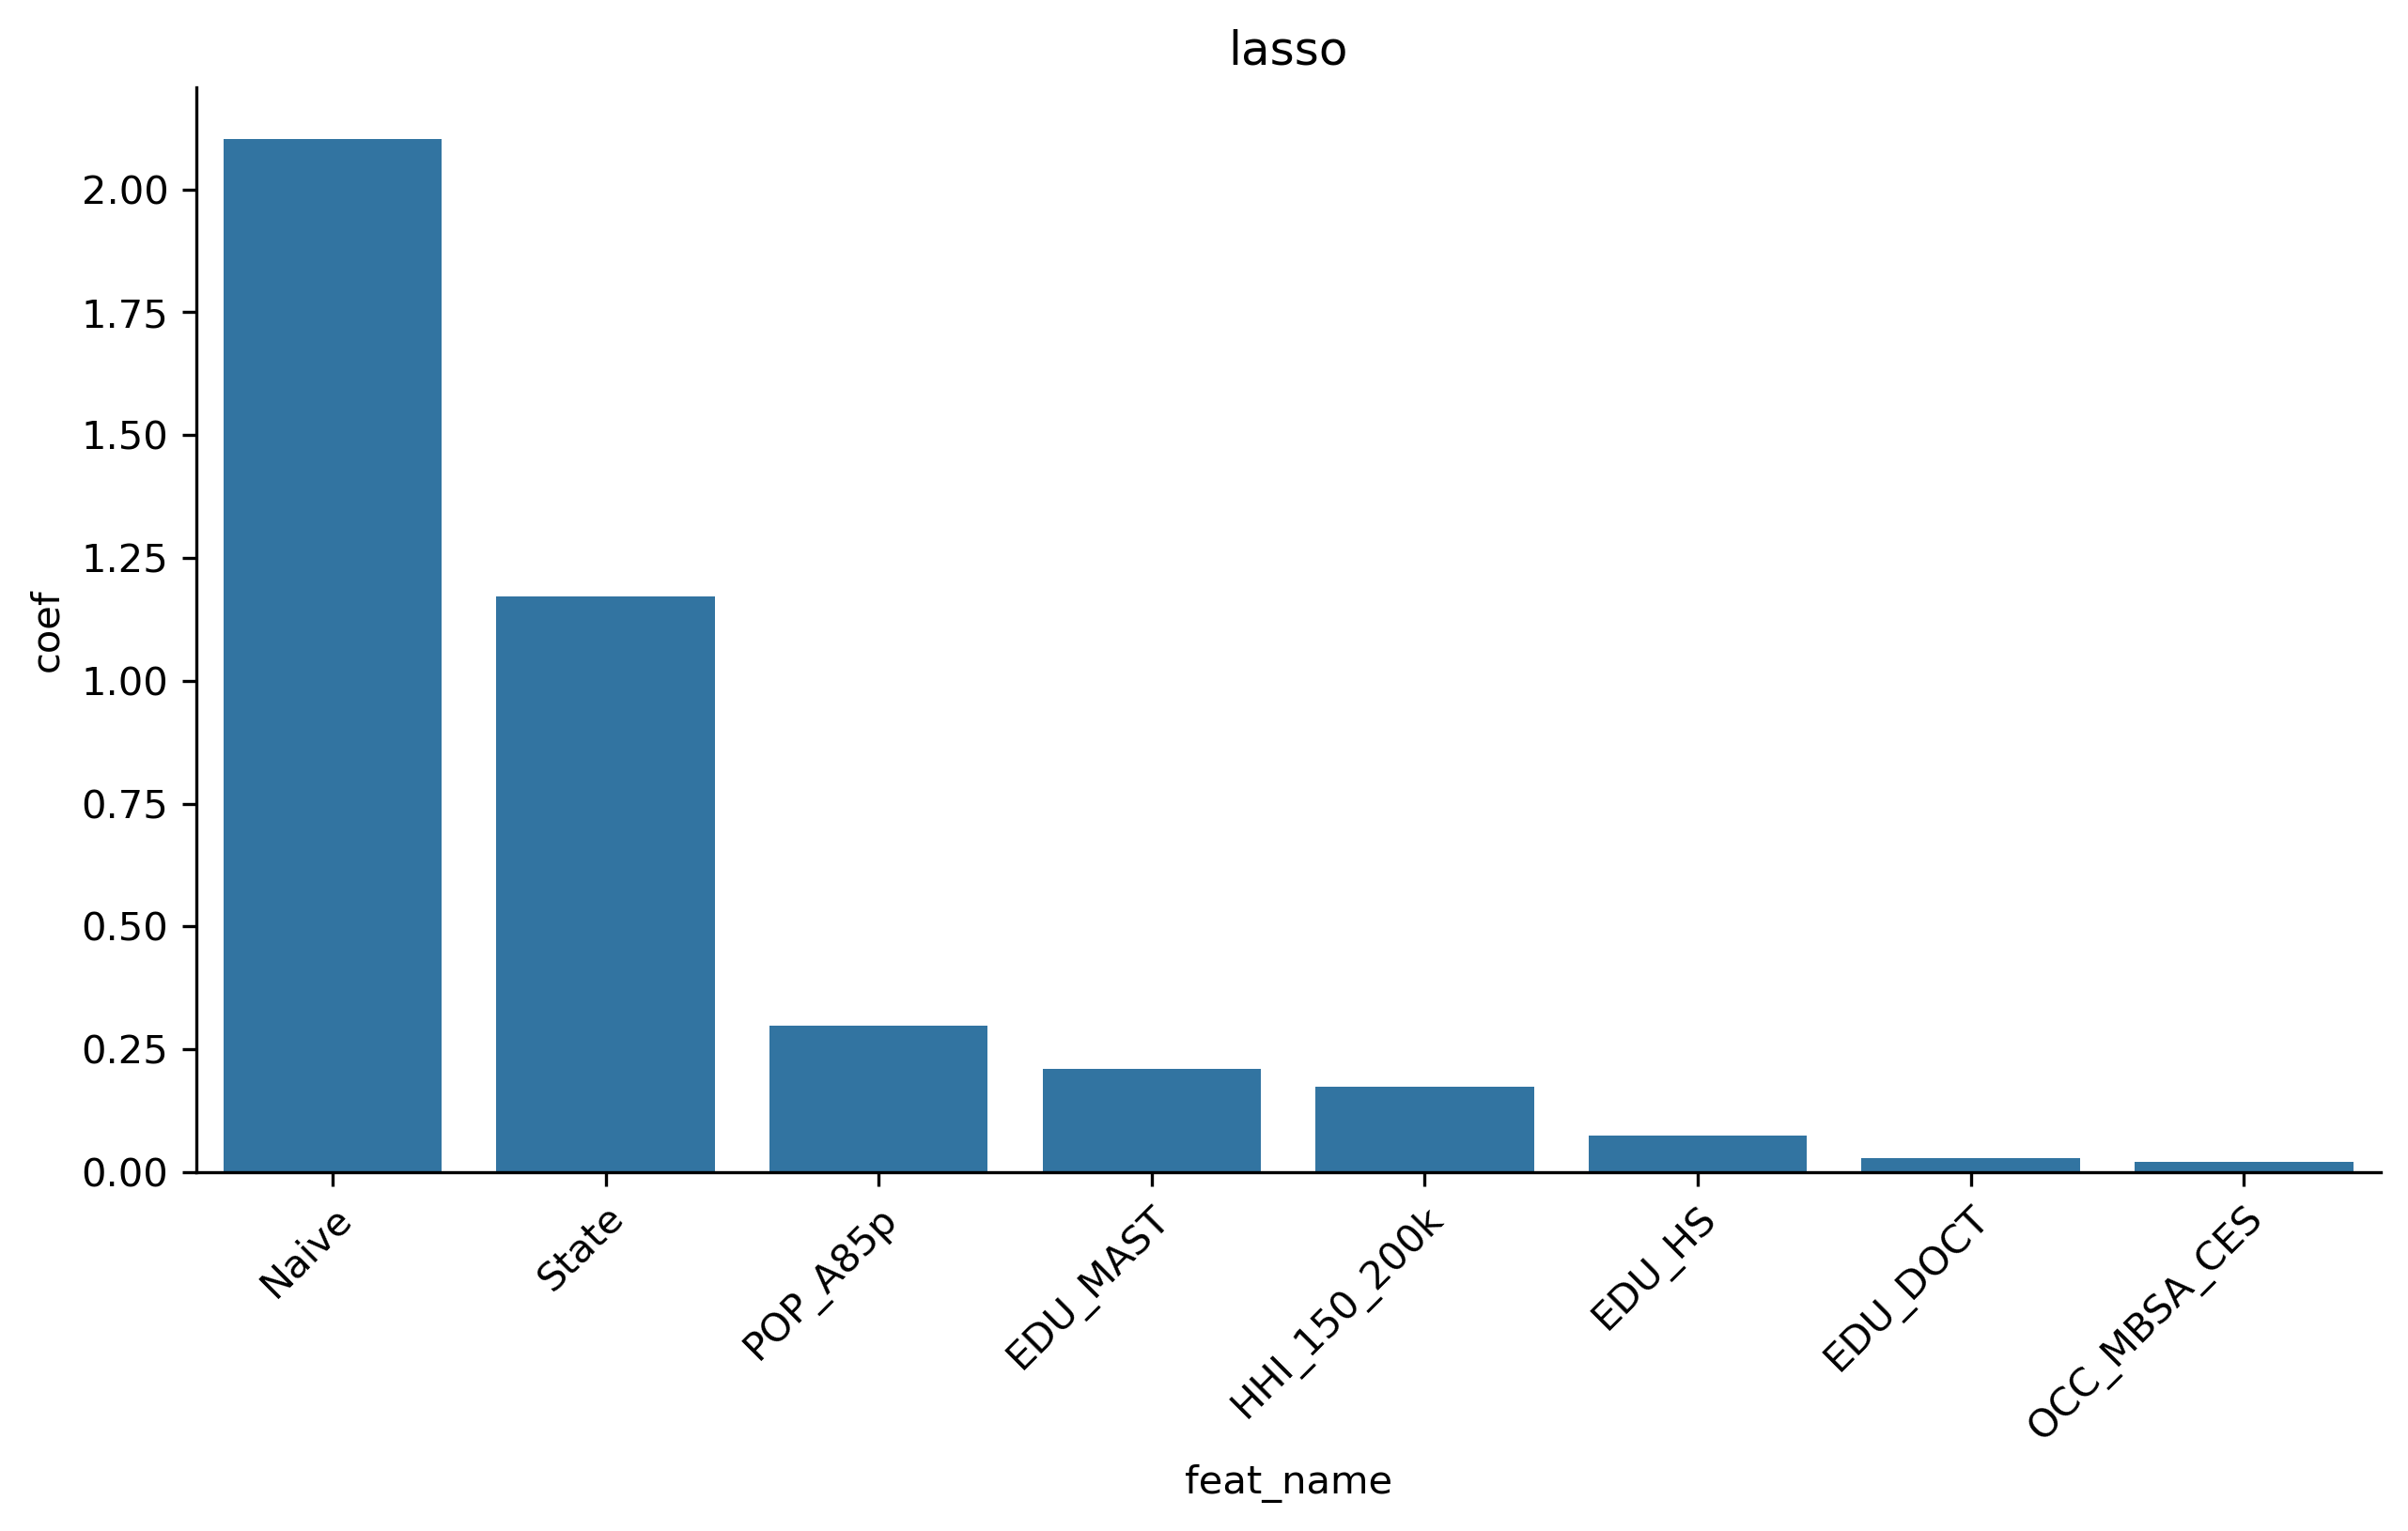

In [12]:
coef = abs(reg.coef_)
ind = np.argpartition(coef, -how_many)[-how_many:]
top = coef[ind]

df_coefs = X_train.iloc[:, ind]
which_feats = df_coefs.columns



res_df = pd.DataFrame([top, which_feats], index=['coef','feat_name'])
res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)
res_df = res_df[:how_many]

import seaborn as sns
import matplotlib.pyplot as plt


DPI = 300

plt.figure(figsize=(10,5))
sns.barplot(res_df, y="coef", x="feat_name", legend=False)
plt.title(f'{alg}')
# plt.xticks(xticks, rotation=45)
plt.xticks(rotation=45,ha='right',wrap='True')

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [9]:
# print(which_feats)
# xticks = [acs_dict[x] for x in res_df['feat_name'].values]
# print(xticks)

# acs_dict = {'POP_NHPINH':'Native Hawaiian and Pac Islander (NonHisp)',
#             'POP_OTH2PLNH': 'Other (NonHisp)',
#             'POP_ASIANNH': 'Asian (NonHisp)',
#             'POP_AIANNH': 'Am Indian and AK native (NonHisp)',
#             'POP_HISP_x12': 'Hispanic',
#             'POP_NH': 'NonHisp',
#             'POP_BLACKNH': 'Black (NonHisp)',
#             'POP_WHITENH': 'White (NonHisp)',            
#            }


# acs_dict = {'EDU_DOCT':'PhD pop',
#             'HHI_125_150k': 'Income 125-150k',
#             'HHI_10_15k': 'Income 10-15k',
#             'HINS_A3564': 'Health ins\n(age 35-64)',
#             'HHI_150_200k': 'Income 150-200k',
#             'Naive': 'Naive',
#             'POP_A85p': 'Pop age >= 85',
#             'EDU_BACH': 'BS pop',
#             'State':'State',
            
#            }

# which_featss = [acs_dict[x] for x in which_feats]



# xticks = [acs_dict[x] for x in res_df['feat_name'].values]
# print(xticks)

Index(['HHI_45_50k', 'HHI_30_35k', 'IND_TWU_TW', 'HHI_35_40k', 'Naive',
       'OCC_PTMM_MM_x11', 'OCC_SERV_PCS_x11', 'Pop'],
      dtype='object')
